In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout

2023-08-09 17:02:15.703783: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 17:02:16.259764: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-08-09 17:02:16.886439: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 17:02:16.980227: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 17:02:16.980644: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

2023-08-09 17:02:16.997574: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 17:02:16.998031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 17:02:16.998368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Default GPU Device: /device:GPU:0


s-bus-pci#L344-L355
2023-08-09 17:02:18.207566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 17:02:18.207910: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 17:02:18.208151: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 2695 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


2023-08-09 17:08:19.232187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 17:08:19.232572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 17:08:19.232842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
data_folder = 'Data_SNIa_LSST/larger/'
df_data = pd.read_csv(data_folder+'hubble_diagram.txt', skiprows=5, sep=' ')
# Np = len(dfp.values)
# N s=  len(dfs.values)
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702


In [6]:
len(df_data)

5785

In [7]:
# df_cov = pd.read_csv(data_folder+'covsys_000.txt', sep='\\n')
# df_cov.head()

In [8]:
# cov = df_cov.values
# len(cov)

In [9]:
# cov = cov.reshape((len(df_data), len(df_data)))
# np.shape(cov)

In [10]:
df_data['errors'] = df_data['MUERR'].values+df_data['MUERR_SYS'].values
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS,errors
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796,0.13996
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720,0.16230
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771,0.13201
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717,0.15157
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702,0.13022


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


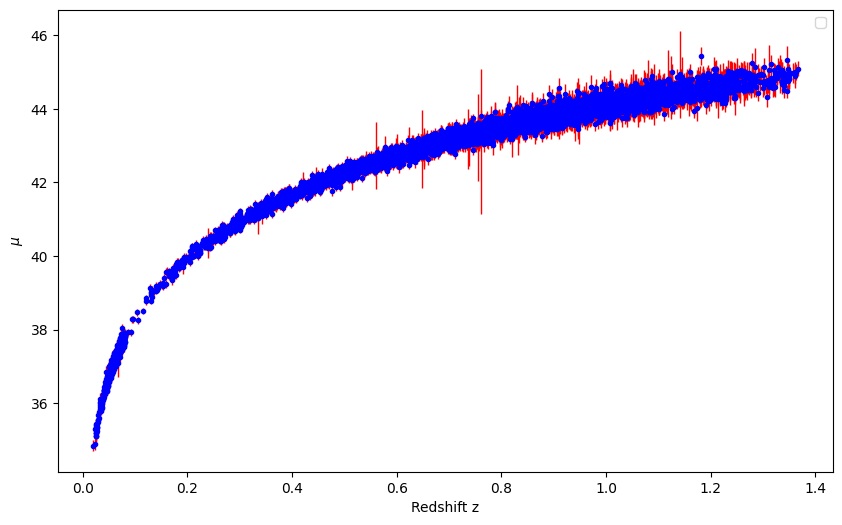

In [11]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(df_data['zCMB'].values, df_data['MU'].values, yerr=df_data['errors'].values, fmt='.', color='b', elinewidth=1, ecolor='red')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [12]:
df_data = df_data[['zCMB', 'MU', 'errors']]

In [13]:
len(df_data)

5785

In [14]:
df_data.head()

,zCMB,MU,errors
0,0.01988,34.84680,0.13996
1,0.02321,34.89863,0.16230
2,0.02364,35.28915,0.13201
3,0.02470,35.11988,0.15157
4,0.02471,35.19347,0.13022


In [15]:
z = df_data[['zCMB']].values
y = df_data[['MU', 'errors']].values

randomize = np.random.permutation(len(z))
z = z[randomize]
y = y[randomize]

In [16]:
zmin, zmax = np.min(z), np.max(z)
zmin, zmax

(0.01988, 1.36643)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


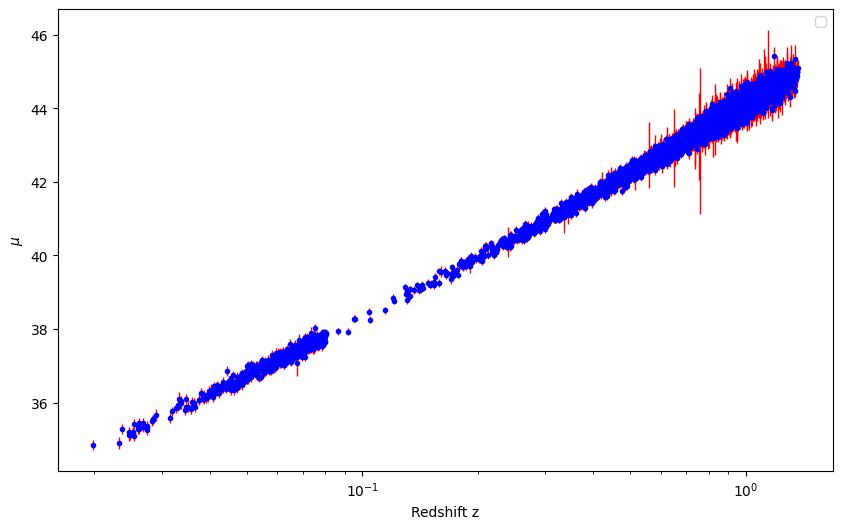

In [17]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(z, y[:,0], yerr=y[:,1], fmt='.', color='b', elinewidth=1, ecolor='red')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.xscale('log')
plt.legend()

In [18]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [19]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [20]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [21]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
yy_train = np.append(yy_train, np.array([y[0], y[-1]]))
zz_train = np.append(zz_train, np.array([zz[0], zz[-1]]))
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((4630,), (4632,), (1157, 1), (1157, 1))

In [23]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.1))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 32
# optimizer = Adam(lr=.005)
optimizer = Adam(learning_rate=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[200, 200,200,200])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 200)               400       
                                                                 
 MCDropout_4 (MCDropout)     (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 200)               40200     
                                                                 
 MCDropout_5 (MCDropout)     (None, 200)               0         
                                                                 
 dense_6 (Dense)             (None, 200)               40200     
                                                                 
 MCDropout_6 (MCDropout)     (None, 200)               0         
                                                                 
 dense_7 (Dense)             (None, 200)              

In [24]:
model.compile(loss='mse', optimizer=optimizer) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=500)
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=2000, verbose=1,
                                    validation_data=(z_test, y_test), callbacks=callback)

Epoch 1/2000
145/145 [==============================] - 2s 4ms/step - loss: 742.8279 - val_loss: 249.3563
Epoch 2/2000
145/145 [==============================] - 0s 2ms/step - loss: 139.1453 - val_loss: 91.4171
Epoch 3/2000
145/145 [==============================] - 0s 2ms/step - loss: 52.5433 - val_loss: 23.9659
Epoch 4/2000
145/145 [==============================] - 0s 2ms/step - loss: 10.8908 - val_loss: 5.8463
Epoch 5/2000
145/145 [==============================] - 0s 2ms/step - loss: 5.5886 - val_loss: 5.5779
Epoch 6/2000
145/145 [==============================] - 0s 2ms/step - loss: 5.3280 - val_loss: 5.2315
Epoch 7/2000
145/145 [==============================] - 0s 2ms/step - loss: 5.1094 - val_loss: 4.7998
Epoch 8/2000
145/145 [==============================] - 0s 2ms/step - loss: 5.0002 - val_loss: 4.4606
Epoch 9/2000
145/145 [==============================] - 0s 2ms/step - loss: 4.6939 - val_loss: 4.7449
Epoch 10/2000
145/145 [==============================] - 0s 2ms/step - l

145/145 [==============================] - 0s 2ms/step - loss: 2.2201 - val_loss: 2.1379
Epoch 81/2000
145/145 [==============================] - 0s 2ms/step - loss: 2.2579 - val_loss: 2.1745
Epoch 82/2000
145/145 [==============================] - 0s 2ms/step - loss: 2.2608 - val_loss: 2.2184
Epoch 83/2000
145/145 [==============================] - 0s 2ms/step - loss: 2.3098 - val_loss: 2.2449
Epoch 84/2000
145/145 [==============================] - 0s 2ms/step - loss: 2.2559 - val_loss: 2.0763
Epoch 85/2000
145/145 [==============================] - 0s 2ms/step - loss: 2.1426 - val_loss: 2.1057
Epoch 86/2000
145/145 [==============================] - 0s 2ms/step - loss: 2.1725 - val_loss: 2.2098
Epoch 87/2000
145/145 [==============================] - 0s 2ms/step - loss: 2.1087 - val_loss: 2.1338
Epoch 88/2000
145/145 [==============================] - 0s 2ms/step - loss: 2.1814 - val_loss: 2.1052
Epoch 89/2000
145/145 [==============================] - 0s 2ms/step - loss: 2.1922 - v

145/145 [==============================] - 0s 2ms/step - loss: 1.8009 - val_loss: 1.7976
Epoch 160/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.8063 - val_loss: 1.6515
Epoch 161/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.7684 - val_loss: 1.8318
Epoch 162/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.7502 - val_loss: 1.8116
Epoch 163/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.8182 - val_loss: 1.9692
Epoch 164/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.8178 - val_loss: 1.7495
Epoch 165/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.7933 - val_loss: 1.7033
Epoch 166/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.7130 - val_loss: 1.8174
Epoch 167/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.7926 - val_loss: 1.6843
Epoch 168/2000
145/145 [==============================] - 0s 2ms/step - loss: 1

Epoch 238/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.5964 - val_loss: 1.6175
Epoch 239/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.5306 - val_loss: 1.5997
Epoch 240/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.5824 - val_loss: 1.5437
Epoch 241/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.6175 - val_loss: 1.5817
Epoch 242/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.6569 - val_loss: 1.4998
Epoch 243/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.6072 - val_loss: 1.5645
Epoch 244/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.5761 - val_loss: 1.4389
Epoch 245/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.5883 - val_loss: 1.5526
Epoch 246/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.5742 - val_loss: 1.6059
Epoch 247/2000
145/145 [==============================] - 0s 2ms

Epoch 317/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.5334 - val_loss: 1.3489
Epoch 318/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.5167 - val_loss: 1.5234
Epoch 319/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.4954 - val_loss: 1.4249
Epoch 320/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.4731 - val_loss: 1.5453
Epoch 321/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.4873 - val_loss: 1.4754
Epoch 322/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.4533 - val_loss: 1.4700
Epoch 323/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.4911 - val_loss: 1.5625
Epoch 324/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.4253 - val_loss: 1.4911
Epoch 325/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.4543 - val_loss: 1.5155
Epoch 326/2000
145/145 [==============================] - 0s 2ms

Epoch 396/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.4548 - val_loss: 1.4613
Epoch 397/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.4058 - val_loss: 1.4055
Epoch 398/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.4592 - val_loss: 1.4761
Epoch 399/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.4003 - val_loss: 1.3826
Epoch 400/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.4189 - val_loss: 1.3580
Epoch 401/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.4806 - val_loss: 1.4874
Epoch 402/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.4641 - val_loss: 1.5077
Epoch 403/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.4375 - val_loss: 1.4110
Epoch 404/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.4577 - val_loss: 1.4085
Epoch 405/2000
145/145 [==============================] - 0s 2ms

Epoch 475/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.3535 - val_loss: 1.3975
Epoch 476/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.3947 - val_loss: 1.3401
Epoch 477/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.3722 - val_loss: 1.2645
Epoch 478/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.4117 - val_loss: 1.3466
Epoch 479/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.3661 - val_loss: 1.3437
Epoch 480/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.4091 - val_loss: 1.3603
Epoch 481/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.3373 - val_loss: 1.2609
Epoch 482/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.3923 - val_loss: 1.3644
Epoch 483/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.3902 - val_loss: 1.3191
Epoch 484/2000
145/145 [==============================] - 0s 2ms

Epoch 554/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.3144 - val_loss: 1.2413
Epoch 555/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.3555 - val_loss: 1.2972
Epoch 556/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.2979 - val_loss: 1.3354
Epoch 557/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.3237 - val_loss: 1.3915
Epoch 558/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.2844 - val_loss: 1.1515
Epoch 559/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.3197 - val_loss: 1.3100
Epoch 560/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.2919 - val_loss: 1.2988
Epoch 561/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.3029 - val_loss: 1.3320
Epoch 562/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.3542 - val_loss: 1.3975
Epoch 563/2000
145/145 [==============================] - 0s 2ms

Epoch 633/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.2780 - val_loss: 1.3220
Epoch 634/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.2270 - val_loss: 1.2819
Epoch 635/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.2493 - val_loss: 1.1822
Epoch 636/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.2751 - val_loss: 1.1545
Epoch 637/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.2530 - val_loss: 1.2906
Epoch 638/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.2844 - val_loss: 1.2824
Epoch 639/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.2212 - val_loss: 1.3023
Epoch 640/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.2456 - val_loss: 1.3086
Epoch 641/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.1994 - val_loss: 1.2348
Epoch 642/2000
145/145 [==============================] - 0s 2ms

Epoch 712/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.2017 - val_loss: 1.2449
Epoch 713/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.2063 - val_loss: 1.1237
Epoch 714/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.1881 - val_loss: 1.1860
Epoch 715/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.1887 - val_loss: 1.2211
Epoch 716/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.2131 - val_loss: 1.2425
Epoch 717/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.2488 - val_loss: 1.3023
Epoch 718/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.2411 - val_loss: 1.1268
Epoch 719/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.2034 - val_loss: 1.2274
Epoch 720/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.2254 - val_loss: 1.3261
Epoch 721/2000
145/145 [==============================] - 0s 2ms

Epoch 791/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.1421 - val_loss: 1.0478
Epoch 792/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.1646 - val_loss: 1.0535
Epoch 793/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.1864 - val_loss: 1.1575
Epoch 794/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.1251 - val_loss: 1.0915
Epoch 795/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.1189 - val_loss: 1.1266
Epoch 796/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.1389 - val_loss: 1.1120
Epoch 797/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.1058 - val_loss: 1.0766
Epoch 798/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.1783 - val_loss: 1.1998
Epoch 799/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.1163 - val_loss: 1.1585
Epoch 800/2000
145/145 [==============================] - 0s 2ms

Epoch 870/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.0983 - val_loss: 1.0892
Epoch 871/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.1046 - val_loss: 0.9802
Epoch 872/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.1231 - val_loss: 1.0735
Epoch 873/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.1256 - val_loss: 1.0801
Epoch 874/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.1316 - val_loss: 1.1209
Epoch 875/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.0579 - val_loss: 1.1197
Epoch 876/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.1173 - val_loss: 1.0507
Epoch 877/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.1087 - val_loss: 1.1553
Epoch 878/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.1146 - val_loss: 1.0541
Epoch 879/2000
145/145 [==============================] - 0s 2ms

Epoch 949/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.0521 - val_loss: 1.0567
Epoch 950/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.0268 - val_loss: 1.0971
Epoch 951/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.0418 - val_loss: 1.0841
Epoch 952/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.0563 - val_loss: 1.1450
Epoch 953/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.0496 - val_loss: 0.9694
Epoch 954/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.0344 - val_loss: 1.0859
Epoch 955/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.0441 - val_loss: 1.0430
Epoch 956/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.0500 - val_loss: 1.1188
Epoch 957/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.0581 - val_loss: 1.0485
Epoch 958/2000
145/145 [==============================] - 0s 2ms

145/145 [==============================] - 0s 2ms/step - loss: 1.0270 - val_loss: 1.1078
Epoch 1028/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.0142 - val_loss: 0.9362
Epoch 1029/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.0333 - val_loss: 0.9613
Epoch 1030/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.0237 - val_loss: 1.0128
Epoch 1031/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.0119 - val_loss: 1.0634
Epoch 1032/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.0447 - val_loss: 1.0071
Epoch 1033/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.0285 - val_loss: 1.0399
Epoch 1034/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.0067 - val_loss: 1.0033
Epoch 1035/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.0111 - val_loss: 0.9719
Epoch 1036/2000
145/145 [==============================] - 0s 2ms/step 

145/145 [==============================] - 0s 2ms/step - loss: 0.9879 - val_loss: 0.9377
Epoch 1106/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9607 - val_loss: 0.9997
Epoch 1107/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9695 - val_loss: 1.0198
Epoch 1108/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9793 - val_loss: 0.9477
Epoch 1109/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9863 - val_loss: 0.9848
Epoch 1110/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.0052 - val_loss: 0.9791
Epoch 1111/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9839 - val_loss: 1.0007
Epoch 1112/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9813 - val_loss: 0.9772
Epoch 1113/2000
145/145 [==============================] - 0s 2ms/step - loss: 1.0098 - val_loss: 0.9394
Epoch 1114/2000
145/145 [==============================] - 0s 2ms/step 

145/145 [==============================] - 0s 2ms/step - loss: 0.9815 - val_loss: 0.9612
Epoch 1184/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9796 - val_loss: 0.9872
Epoch 1185/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9452 - val_loss: 0.9116
Epoch 1186/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9351 - val_loss: 0.8970
Epoch 1187/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9431 - val_loss: 0.9451
Epoch 1188/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9899 - val_loss: 0.8580
Epoch 1189/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9668 - val_loss: 0.9480
Epoch 1190/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9659 - val_loss: 0.9489
Epoch 1191/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9326 - val_loss: 0.9122
Epoch 1192/2000
145/145 [==============================] - 0s 2ms/step 

145/145 [==============================] - 0s 2ms/step - loss: 0.9218 - val_loss: 1.0163
Epoch 1262/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9306 - val_loss: 0.9153
Epoch 1263/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9105 - val_loss: 0.8819
Epoch 1264/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9274 - val_loss: 0.8886
Epoch 1265/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9024 - val_loss: 0.8287
Epoch 1266/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9059 - val_loss: 0.8783
Epoch 1267/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9180 - val_loss: 0.9343
Epoch 1268/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9478 - val_loss: 0.9888
Epoch 1269/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9252 - val_loss: 0.8895
Epoch 1270/2000
145/145 [==============================] - 0s 2ms/step 

145/145 [==============================] - 0s 2ms/step - loss: 0.8885 - val_loss: 0.9934
Epoch 1340/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8992 - val_loss: 0.8877
Epoch 1341/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9215 - val_loss: 0.8511
Epoch 1342/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9078 - val_loss: 0.9319
Epoch 1343/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8657 - val_loss: 0.8567
Epoch 1344/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9069 - val_loss: 0.8884
Epoch 1345/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9023 - val_loss: 0.9043
Epoch 1346/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9072 - val_loss: 0.9163
Epoch 1347/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8733 - val_loss: 0.9499
Epoch 1348/2000
145/145 [==============================] - 0s 2ms/step 

145/145 [==============================] - 0s 2ms/step - loss: 0.8488 - val_loss: 0.8582
Epoch 1418/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8495 - val_loss: 0.8963
Epoch 1419/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8755 - val_loss: 0.8479
Epoch 1420/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8875 - val_loss: 0.7715
Epoch 1421/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8982 - val_loss: 0.8805
Epoch 1422/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8601 - val_loss: 0.9154
Epoch 1423/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.9229 - val_loss: 0.9047
Epoch 1424/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8578 - val_loss: 0.8800
Epoch 1425/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8774 - val_loss: 0.9487
Epoch 1426/2000
145/145 [==============================] - 0s 2ms/step 

145/145 [==============================] - 0s 2ms/step - loss: 0.8540 - val_loss: 0.7799
Epoch 1496/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8460 - val_loss: 0.8755
Epoch 1497/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8539 - val_loss: 0.9334
Epoch 1498/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8784 - val_loss: 0.8869
Epoch 1499/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8486 - val_loss: 0.8582
Epoch 1500/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8724 - val_loss: 0.8286
Epoch 1501/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8661 - val_loss: 0.7809
Epoch 1502/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8586 - val_loss: 0.8505
Epoch 1503/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8968 - val_loss: 0.9113
Epoch 1504/2000
145/145 [==============================] - 0s 2ms/step 

145/145 [==============================] - 0s 2ms/step - loss: 0.8139 - val_loss: 0.8290
Epoch 1574/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8221 - val_loss: 0.8794
Epoch 1575/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8657 - val_loss: 0.8237
Epoch 1576/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8662 - val_loss: 0.8269
Epoch 1577/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8323 - val_loss: 0.8760
Epoch 1578/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8390 - val_loss: 0.8316
Epoch 1579/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8141 - val_loss: 0.8269
Epoch 1580/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8727 - val_loss: 0.8822
Epoch 1581/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8427 - val_loss: 0.9116
Epoch 1582/2000
145/145 [==============================] - 0s 2ms/step 

145/145 [==============================] - 0s 2ms/step - loss: 0.8159 - val_loss: 0.8527
Epoch 1652/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8183 - val_loss: 0.7483
Epoch 1653/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8281 - val_loss: 0.8079
Epoch 1654/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8023 - val_loss: 0.8757
Epoch 1655/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8202 - val_loss: 0.7778
Epoch 1656/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8126 - val_loss: 0.8585
Epoch 1657/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.7901 - val_loss: 0.8907
Epoch 1658/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8456 - val_loss: 0.8108
Epoch 1659/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8300 - val_loss: 0.8547
Epoch 1660/2000
145/145 [==============================] - 0s 2ms/step 

145/145 [==============================] - 0s 2ms/step - loss: 0.8019 - val_loss: 0.8123
Epoch 1730/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8351 - val_loss: 0.7942
Epoch 1731/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8215 - val_loss: 0.8185
Epoch 1732/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.7987 - val_loss: 0.7767
Epoch 1733/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8179 - val_loss: 0.8131
Epoch 1734/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8070 - val_loss: 0.8251
Epoch 1735/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.7940 - val_loss: 0.8375
Epoch 1736/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.7843 - val_loss: 0.8167
Epoch 1737/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8393 - val_loss: 0.8214
Epoch 1738/2000
145/145 [==============================] - 0s 2ms/step 

145/145 [==============================] - 0s 2ms/step - loss: 0.8053 - val_loss: 0.7800
Epoch 1808/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.7914 - val_loss: 0.7850
Epoch 1809/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.7772 - val_loss: 0.8097
Epoch 1810/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8295 - val_loss: 0.8297
Epoch 1811/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.7706 - val_loss: 0.8428
Epoch 1812/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8201 - val_loss: 0.8659
Epoch 1813/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8011 - val_loss: 0.8245
Epoch 1814/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.7969 - val_loss: 0.8366
Epoch 1815/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.7986 - val_loss: 0.7906
Epoch 1816/2000
145/145 [==============================] - 0s 2ms/step 

145/145 [==============================] - 0s 2ms/step - loss: 0.8029 - val_loss: 0.8104
Epoch 1886/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.7979 - val_loss: 0.7380
Epoch 1887/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.7808 - val_loss: 0.8489
Epoch 1888/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8223 - val_loss: 0.7867
Epoch 1889/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8000 - val_loss: 0.8002
Epoch 1890/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8144 - val_loss: 0.8182
Epoch 1891/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.7882 - val_loss: 0.7996
Epoch 1892/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.7983 - val_loss: 0.7847
Epoch 1893/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.8033 - val_loss: 0.7290
Epoch 1894/2000
145/145 [==============================] - 0s 2ms/step 

145/145 [==============================] - 0s 2ms/step - loss: 0.8078 - val_loss: 0.8111
Epoch 1964/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.7877 - val_loss: 0.8133
Epoch 1965/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.7674 - val_loss: 0.7730
Epoch 1966/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.7996 - val_loss: 0.8433
Epoch 1967/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.7972 - val_loss: 0.7395
Epoch 1968/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.7811 - val_loss: 0.7239
Epoch 1969/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.7552 - val_loss: 0.7722
Epoch 1970/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.7761 - val_loss: 0.7554
Epoch 1971/2000
145/145 [==============================] - 0s 2ms/step - loss: 0.7521 - val_loss: 0.7656
Epoch 1972/2000
145/145 [==============================] - 0s 2ms/step 

In [25]:
model_train.history['val_loss'][-1]

0.7899436950683594

(0.0, 50.0)

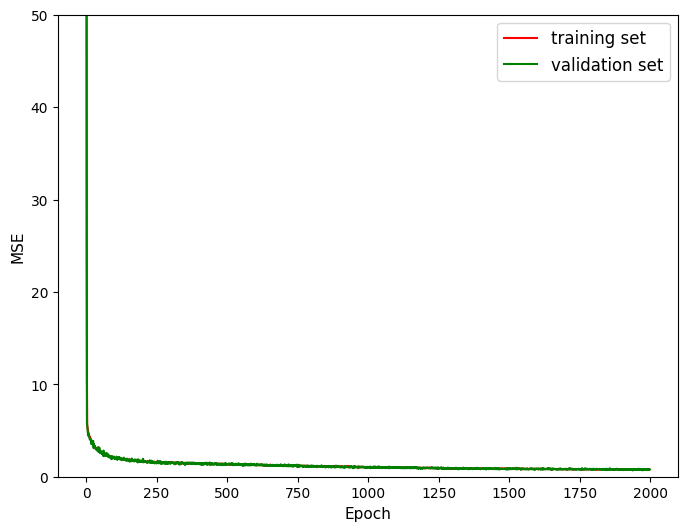

In [26]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.ylim(0, 50)

In [27]:
# Generate test data
test_batch_size = 500
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(zmin, zmax, test_batch_size)

mc_dropout_num = 100 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



16/16 [==============================] - 0s 938us/step


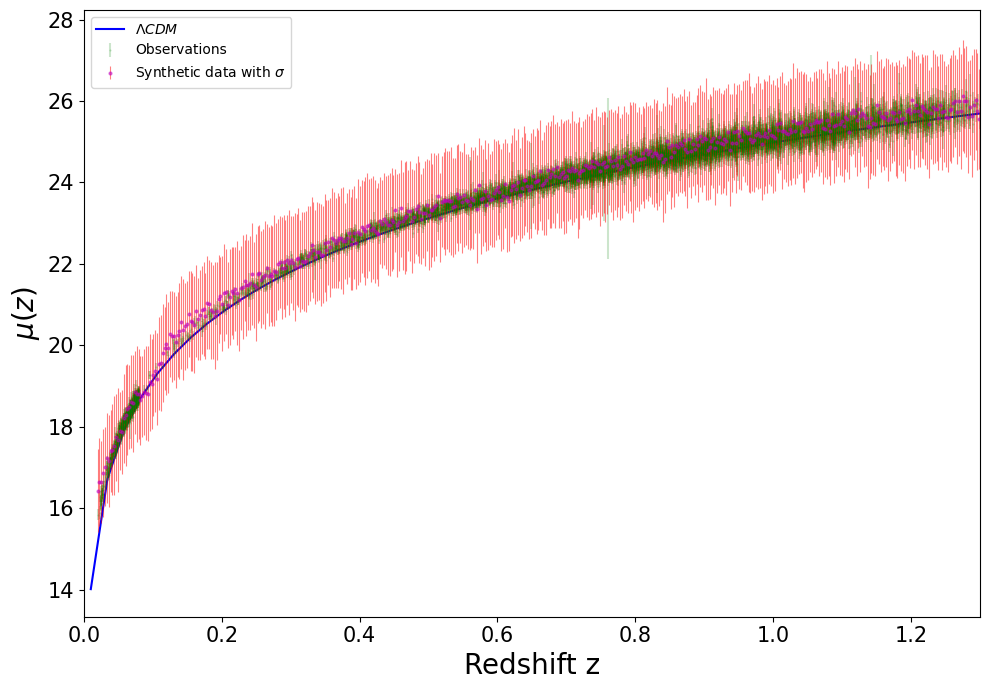

In [28]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.', markersize=1, alpha=0.2, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.5, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,1.3)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

# zCMB 	MU 	errors